In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import sys
# Add everything to our paths.
repo = "/pscratch/sd/m/mwhite/AnalyzeLAE/"
for codedir in ["odin","mocks","Cobaya/lss_likelihood"]:
    sys.path.append(repo+codedir)

In [3]:
import json
# Import the Class class.
from classy import Class
# Import velocileptors.
from velocileptors.LPT.lpt_rsd_fftw import LPT_RSD
# Gamma function for wp(R).
from scipy.special import gamma
# Spline.
from scipy.interpolate import InterpolatedUnivariateSpline as Spline

## Best-fit spectra

Load the clustering of LAEs from the mocks, using pre-generated data files created by AbacusHOD.

In [4]:
# Load the cosmology information from the JSON file.
lae = json.load(open("lae_n501_c000_ph100_s.json","r"))

In [5]:
# The ZCV data are in a separate JSON file.
zcv = json.load(open("lae_n501_c000_ph100_s_zcv.json","r"))
pka = np.zeros( (len(zcv['k']),3) )
pka[:,0] = zcv['k']
pka[:,1] = zcv['pk0']
pka[:,2] = zcv['pk2']

In [6]:
# And the bias data are in yet another file.
bk = np.loadtxt("lae_n501_bk.txt")
#
# Use the bias data to compute P_{gg} and P_{gm}.
knb = bk[:, 0]
pgg = bk[:,-1] * bk[:,1]**2
pgm = bk[:,-1] * bk[:,2]

## Noise curves.

In [7]:
SOn = np.loadtxt("SO_kappa_noise.txt")
S4n = np.loadtxt("S4_kappa_noise.txt")
#
SOn = SOn[:,[0,7]]
S4n = S4n[:,[0,7]]

### Linear theory

First set up the linear theory and background quantities for this cosmology using CLASS.

In [8]:
# Set up the class instance.
params = {
    'output': 'tCl lCl mPk',
    'l_max_scalars': 2000,
    'P_k_max_h/Mpc': 50.,
    'z_pk': '0.0,10',
    'lensing': 'yes',
    'A_s': np.exp(3.040)*1e-10,
    'n_s': 0.96824,
    'h': 0.6770,
    'N_ur': 2.0328,
    'N_ncdm': 1,
    'tau_reio': 0.0568,
    'omega_b': 0.022447,
    'omega_cdm': 0.11923}
# Now update some keys with N-body values.
for k in ['n_s','omega_b','omega_cdm',\
          'omega_ncdm','N_ncdm','N_ur']:
    params[k] = lae[k]
params['h'] = lae['H0']/100.0
#
cosmo = Class()
cosmo.set(params)
cosmo.compute()
#
wb = cosmo.omega_b()
wnu= params['omega_ncdm'] # wnu= 0.0106 * params['m_ncdm']
#
print("OmegaM=",cosmo.Omega_m())
print("sigma8=",cosmo.sigma8())
print("hubble=",cosmo.h())
print("omegab=",wb)
print("omegav=",wnu)
#
cosmo.get_current_derived_parameters(['H0','Omega_Lambda',\
                                      'age','conformal_age','Neff',\
                                      'z_reio','100*theta_s','rs_rec','rs_d'])

OmegaM= 0.3151917236639384
sigma8= 0.8090915366308338
hubble= 0.6736
omegab= 0.02237
omegav= 0.0006442


{'H0': 67.36,
 'Omega_Lambda': 0.6847284676967347,
 'age': 13.797154912501444,
 'conformal_age': 14153.245737831245,
 'Neff': 3.045998221453431,
 'z_reio': 7.9332733154296875,
 '100*theta_s': 1.0418477711693583,
 'rs_rec': 144.5310550407161,
 'rs_d': 147.09704557186203}

In [9]:
zz = lae['Redshift']
ff = cosmo.scale_independent_growth_factor_f(zz)
print("z={:.2f}, f={:.4f}".format(zz,ff))
#
hub= cosmo.h()                # To convert to "conventional" Mpc/h units.
kk = np.logspace(-4.0,1.5,1000)
pk = np.array( [cosmo.pk(k*hub,zz)*hub**3 for k in kk] )
pl = np.array( [cosmo.pk_lin(k*hub,zz)*hub**3 for k in kk] )
#
# Compute the Zeldovich displacement and hence k_{nl}.
knl= 1/np.sqrt( np.trapz(pl,x=kk)/6./np.pi**2 )
print("knl=",knl," h/Mpc.")

z=3.00, f=0.9786
knl= 0.5423896891428361  h/Mpc.


In [10]:
# Work out the kappa auto-spectrum.
cls = cosmo.lensed_cl(2000)
ell = cls['ell'][2:]
fac = 0.25*(ell+2)*(ell+1)*(ell)*(ell-1)  # As per "explanatory.ini" in CLASS.
clkk= cls['pp'][2:] * fac

### LAE data

Get some routines to help massage LAE data.

In [11]:
# Schechter function fits from the literature.  The phi* definition
# is in terms of L, i.e. we need a ln(10) going to lgL [erg/s].
# phi* is in units of Mpc^{-3} and converted to Mpc/h below.
LFlist = []
LFlist.append({'zfid':2.2,'phis':3.37e-4,'Lstar':4.87e42,'alpha':-1.80,\
               'ref':'Konno+16'})
LFlist.append({'zfid':3.1,'phis':3.90e-4,'Lstar':8.49e42,'alpha':-1.80,\
               'ref':'Konno+16'})
LFlist.append({'zfid':3.7,'phis':3.31e-4,'Lstar':9.16e42,'alpha':-1.80,\
               'ref':'Konno+16'})
#LFlist.append({'zfid':3.7,'phis':3.4e-4,'Lstar':1.02e43,'alpha':-1.50,\
#               'ref':'Ouchi+08'})
LFlist.append({'zfid':5.7,'phis':4.44e-4,'Lstar':9.09e42,'alpha':-1.80,\
               'ref':'Konno+16'})

In [12]:
def nbar_fit(lgL,zz):
    """Computes nbar, in [Mpc/h]^{-3}, given line luminosity lgL [erg/s]
    for LAEs."""
    # Choose the closest redshift in the table.
    delz= np.array([np.abs(zz-lf['zfid']) for lf in LFlist])
    lf  = LFlist[np.argmin(delz)]
    # Get the Schechter paramerers, converting to Mpc/h units.
    hub = cosmo.h()
    phis,lgLstar,alpha = lf['phis']/hub**3,np.log10(lf['Lstar']),lf['alpha']
    # Just brute-force the Schechter integral, it's plenty fast enough.
    logl = np.linspace(lgL,lgLstar+10,1000)
    ll   = 10.0**(logl-lgLstar)
    lf   = np.log(10)*phis * ll**(alpha+1) * np.exp(-ll)
    nbar = np.trapz(lf,logl)
    return(nbar)

In [13]:
def flux2L(zz):
    """Convert a flux in erg/s/cm2 to log10(L) in [erg/s].
    Add the returned value to log10(flux) to get log10(L)."""
    Mpc_cm = 3.086e24 # 1 Mpc in cm.
    dL     = cosmo.luminosity_distance(zz)
    val    = np.log10(4*np.pi)+2*(np.log10(dL)+np.log10(Mpc_cm))
    return(val)

In [14]:
# Some helpful numbers.
flux = 5e-17
lgL  = np.log10(flux) + flux2L(zz)
chi  = cosmo.comoving_distance(zz) * cosmo.h()
nbar = nbar_fit(lgL,zz)
#
print("z    ={:5.1f}".format(zz))
print("Flux ={:10.2e} [erg/s/cm^2]".format(flux))
print("lgL  ={:6.2f} [erg/s]".format(lgL))
print("nbar ={:10.2e}".format(nbar)+r' [Mpc/h]^3')
print("chi  ={:5.0f}Mpc/h".format(chi))

z    =  3.0
Flux =  5.00e-17 [erg/s/cm^2]
lgL  = 42.61 [erg/s]
nbar =  8.61e-04 [Mpc/h]^3
chi  = 4383Mpc/h


## Now make the figure.

In [15]:
fsky= 0.30
zmin= 2.75
zmax= 3.25
dchi= (cosmo.comoving_distance(zmax)-cosmo.comoving_distance(zmin)) * cosmo.h()
vol = chi**2 * dchi
print("fsky={:.2f}".format(fsky))
print("Distance for {:.2f}<z<{:.2f} is {:5.0f}Mpc/h.".format(zmin,zmax,dchi))
print("Volume per sr is {:10.2e} [Mpc/h]^3".format(vol))
#
chis= 9400.0 # Distance to last-scattering in Mpc/h.
wgk = 1.5*cosmo.Omega_m()/2997.925**2*(1+zz)*chi*(chis-chi)/chis
wgk/= chi**2

fsky=0.30
Distance for 2.75<z<3.25 is   329Mpc/h.
Volume per sr is   6.32e+09 [Mpc/h]^3


In [16]:
clgg = np.interp(ell,chi*knb,(pgg+1/nbar)/vol)
clgk = np.interp(ell,chi*knb,pgm*wgk)

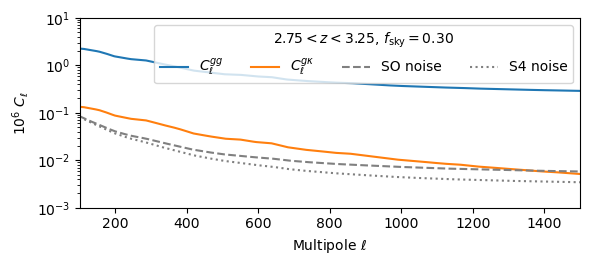

In [17]:
# Make the figure.
fig,ax = plt.subplots(1,1,figsize=(6,2.75))
# First do Simons.
ax.plot(ell,1e6*clgg,'-',color='C0',label=r'$C_\ell^{gg}$')
ax.plot(ell,1e6*clgk,'-',color='C1',label=r'$C_\ell^{g\kappa}$')
##ax.plot(ell,1e6*clkk,'-',color='C2',label=r'$C_\ell^{\kappa\kappa}$')
#
Nell = 1.0/(2*ell+1)/fsky*( clgg*(clkk+np.interp(ell,SOn[:,0],SOn[:,1]))+clgk**2 )
Nell = np.sqrt(Nell)
ax.plot(ell,1e6*Nell,'--',color='gray',label=r'SO noise')
#
Nell = 1.0/(2*ell+1)/fsky*( clgg*(clkk+np.interp(ell,S4n[:,0],S4n[:,1]))+clgk**2 )
Nell = np.sqrt(Nell)
ax.plot(ell,1e6*Nell,':',color='gray',label=r'S4 noise')
#
ax.legend(title='${:.2f}<z<{:.2f}$,'.format(zmin,zmax)+r' $f_{\rm sky}='+'{:.2f}$'.format(fsky),loc=1,ncol=4)
ax.set_xlim(100.,1500)
ax.set_ylim(1e-3,10.0)
ax.set_yscale('log')
ax.set_xlabel(r'Multipole $\ell$')
ax.set_ylabel(r'$10^6\ C_\ell$')
#
plt.tight_layout()
plt.savefig('lae_cmb_lensing.pdf')
plt.savefig('lae_cmb_lensing.png')

# Done